In [1]:
import myutil as mu
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset  # 텐서데이터셋
from torch.utils.data import DataLoader  # 데이터로더
from torch.utils.data import Dataset
import matplotlib.pyplot as plt  # 맷플롯립사용
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import random
from sklearn.datasets import load_digits



--- 
 - CNN으로 MNIST 분류하기 
   - 이번 챕터에서는 CNN으로 MNIST를 분류해보겠습니다. 


--- 
 임의의 텐서를 만듭니다. 텐서의 크기는 1 × 1 × 28 × 28입니다. 


In [2]:
inputs = torch.Tensor(1, 1, 28, 28)
mu.log("inputs", inputs)




inputs : 
    torch.Size([1, 1, 28, 28]) tensor([[[[-5.7412e+07,  4.5712e-41,  1.5414e-44,  0.0000e+00,  0.0000e+00,
                0.0000e+00,  ...



--- 
 - 합성곱층과 풀링 선언하기 
   - 이제 첫번째 합성곱 층을 구현해봅시다. 
   - 1채널 짜리를 입력받아서 32채널을 뽑아내는데 커널 사이즈는 3이고 패딩은 1입니다. 


In [3]:
conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3), padding=(1, 1))
mu.log("conv1", conv1)



conv1 : 
    Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) 
    torch.Size([32, 1, 3, 3]) tensor([[[[ 0.1136, -0.3329, -0.2063],
              [-0.2326, -0.0497, -0.2653],
              [ 0.2389, -0 ...
    torch.Size([32]) tensor([-0.2414,  0.2156, -0.0568,  0.2838,  0.1000,  0.0281, -0.0484,  0.0964,
            -0.2412, -0. ...



--- 
 - 이제 두번째 합성곱 층을 구현해봅시다. 
   - 32채널 짜리를 입력받아서 64채널을 뽑아내는데 커널 사이즈는 3이고 패딩은 1입니다. 


In [4]:
conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=(1, 1))
mu.log("conv2", conv2)



conv2 : 
    Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) 
    torch.Size([64, 32, 3, 3]) tensor([[[[ 5.8330e-02,  2.6579e-02,  4.1431e-02],
              [-3.1966e-02, -1.0294e-02,  5.2576e-02] ...
    torch.Size([64]) tensor([-3.8194e-02,  2.2961e-02, -3.6868e-02, -3.9716e-02,  5.1850e-02,
             3.3440e-02, -4.684 ...



--- 
 - 이제 맥스풀링을 구현해봅시다. 
   - 정수 하나를 인자로 넣으면 커널 사이즈와 스트라이드가 둘 다 해당값으로 지정됩니다. 


In [5]:
pool = nn.MaxPool2d(kernel_size=(2, 2))
mu.log("pool", pool)



pool : 
    MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False) 



--- 
 - 구현체를 연결하여 모델 만들기 
   - 지금까지는 선언만한 것이고 아직 이들을 연결시키지는 않았습니다. 
   - 이들을 연결시켜서 모델을 완성시켜보겠습니다. 
   - 우선 입력을 첫번째 합성곱층을 통과시키고 합성곱층을 통과시킨 후의 텐서의 크기를 보겠습니다. 


In [6]:
out = conv1(inputs)
mu.log("out = conv1(inputs)", out)



out = conv1(inputs) : 
    torch.Size([1, 32, 28, 28]) tensor([[[[ 2.8533e+06,         nan,         nan,  ..., -2.4139e-01,
               -2.4139e-01, -2.4139 ...



--- 
 - 32채널의 28너비 28높이의 텐서가 되었습니다. 
 - 32가 나온 이유는 conv1의 out_channel로 32를 지정해주었기 때문입니다. 
 - 또한, 28너비 28높이가 된 이유는 패딩을 1폭으로 하고 3 × 3 커널을 사용하면 크기가 보존되기 때문입니다. 
 - 이제 이를 맥스풀링을 통과시키고 맥스풀링을 통과한 후의 텐서의 크기를 보겠습니다. 


In [7]:
out = pool(out)
mu.log("out = pool(out)", out)



out = pool(out) : 
    torch.Size([1, 32, 14, 14]) tensor([[[[        nan,         nan,         nan,  ...,         nan,
               -2.4139e-01, -2.4139 ...



--- 
 - 32채널의 14너비 14높이의 텐서가 되었습니다. 
 - 이제 이를 다시 두번째 합성곱층에 통과시키고 통과한 후의 텐서의 크기를 보겠습니다. 


In [8]:
out = conv2(out)
mu.log("out = conv2(out)", out)



out = conv2(out) : 
    torch.Size([1, 64, 14, 14]) tensor([[[[        nan,         nan,         nan,  ...,         nan,
                       nan,  1.0534 ...



--- 
 - 64채널의 14너비 14높이의 텐서가 되었습니다. 
 - 64가 나온 이유는 conv2의 out_channel로 64를 지정해주었기 때문입니다. 
 - 또한, 14너비 14높이가 된 이유는 패딩을 1폭으로 하고 3 × 3 커널을 사용하면 크기가 보존되기 때문입니다. 
 - 이제 이를 맥스풀링을 통과시키고 맥스풀링을 통과한 후의 텐서의 크기를 보겠습니다. 


In [9]:
out = pool(out)
mu.log("out = pool(out)", out)



out = pool(out) : 
    torch.Size([1, 64, 7, 7]) tensor([[[[        nan,         nan,         nan,  ...,         nan,
                       nan,         ...



--- 
 - 이제 이 텐서를 펼치는 작업을 할 겁니다. 
 - 그런데 펼치기에 앞서 텐서의 n번째 차원을 접근하게 해주는 .size(n)에 대해서 배워보겠습니다. 
 - 현재 out의 크기는 1 × 64 × 7 × 7입니다. 
 - out의 첫번째 차원이 몇인지 출력해보겠습니다. 


In [10]:
mu.log("out.size(0)", out.size(0))
mu.log("out.size(1)", out.size(1))
mu.log("out.size(2)", out.size(2))
mu.log("out.size(3)", out.size(3))



out.size(0) : 1
out.size(1) : 64
out.size(2) : 7
out.size(3) : 7


--- 
 이제 이를 가지고 .view()를 사용하여 텐서를 펼치는 작업을 해보겠습니다. 


In [11]:
out = out.view(out.size(0), -1)
mu.log("out = out.view(out.size(0), -1)", out)
mu.log("out.size(1)", out.size(1))




out = out.view(out.size(0), -1) : 
    torch.Size([1, 3136]) tensor([[       nan,        nan,        nan,  ..., 7.1078e+34, 6.3845e+36,
             4.4825e+36]])

out.size(1) : 3136


--- 
 - 배치 차원을 제외하고 모두 하나의 차원으로 통합된 것을 볼 수 있습니다. 
 - 이제 이에 대해서 전결합층(Fully-Connteced layer)를 통과시켜보겠습니다. 
 - 출력층으로 10개의 뉴런을 배치하여 10개 차원의 텐서로 변환합니다. 


In [12]:
fc = nn.Linear(out.size(1), 10)
mu.log("fc", fc)
out = fc(out)
mu.log("out = fc(out)", out)




fc : 
    Linear(in_features=3136, out_features=10, bias=True) 
    torch.Size([10, 3136]) tensor([[ 0.0029,  0.0118,  0.0160,  ..., -0.0109, -0.0010, -0.0068],
            [-0.0124,  0.0145,  0. ...
    torch.Size([10]) tensor([-0.0104, -0.0138, -0.0080,  0.0147, -0.0151, -0.0090,  0.0090,  0.0094,
            -0.0169,  0. ...

out = fc(out) : 
    torch.Size([1, 10]) tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]])



--- 
 CNN으로 MNIST 분류하기 


In [13]:

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 랜덤 시드 고정
torch.manual_seed(777)

# GPU 사용 가능일 경우 랜덤 시드 고정
if device == 'cuda':
    torch.cuda.manual_seed_all(777)



--- 
 학습에 사용할 파라미터를 설정합니다. 


In [14]:


learning_rate = 0.001
training_epochs = 15
batch_size = 100



--- 
 데이터로더를 사용하여 데이터를 다루기 위해서 데이터셋을 정의해줍니다. 


In [15]:


mnist_train = dsets.MNIST(root='MNIST_data/',  # 다운로드 경로 지정
                          train=True,  # True를 지정하면 훈련 데이터로 다운로드
                          transform=transforms.ToTensor(),  # 텐서로 변환
                          download=True)

mu.log("mnist_train", mnist_train)

mnist_test = dsets.MNIST(root='MNIST_data/',  # 다운로드 경로 지정
                         train=False,  # False를 지정하면 테스트 데이터로 다운로드
                         transform=transforms.ToTensor(),  # 텐서로 변환
                         download=True)

mu.log("mnist_test", mnist_test)

data_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

mu.log("len(data_loader)", len(data_loader))
mu.log("data_loader.sampler.num_samples", data_loader.sampler.num_samples)
mu.log("data_loader.batch_size", data_loader.batch_size)




mnist_train : 
    Dataset MNIST
        Number of datapoints: 60000
        Root location: MNIST_data/
        Split: Train
        StandardTransform
    Transform: ToTensor()

mnist_test : 
    Dataset MNIST
        Number of datapoints: 10000
        Root location: MNIST_data/
        Split: Test
        StandardTransform
    Transform: ToTensor()

len(data_loader) : 600
data_loader.sampler.num_samples : 60000
data_loader.batch_size : 100


--- 
 이제 클래스로 모델을 설계합니다. 


In [16]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        # 첫번째층
        # ImgIn shape=(?, 28, 28, 1)
        #    Conv     -> (?, 28, 28, 32)
        #    Pool     -> (?, 14, 14, 32)
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=2, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # 두번째층
        # ImgIn shape=(?, 14, 14, 32)
        #    Conv      ->(?, 14, 14, 64)
        #    Pool      ->(?, 7, 7, 64)
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=2, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # 전결합층 7x7x64 inputs -> 10 outputs
        self.fc = nn.Linear(in_features=7 * 7 * 64, out_features=10, bias=True)

        # 전결합층 한정으로 가중치 초기화
        nn.init.xavier_normal_(self.fc.weight)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        # 전결합층을 위해서 Flatten
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out




--- 
 모델을 정의합니다. 


In [17]:
model = CNN().to(device)
mu.log("model", model)




model : 
    CNN(
      (layer1): Sequential(
        (0): Conv2d(1, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (layer2): Sequential(
        (0): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (fc): Linear(in_features=3136, out_features=10, bias=True)
    ) 
    torch.Size([32, 1, 2, 2]) tensor([[[[-0.4181, -0.0089],
              [-0.0967, -0.1141]]],
    
    
            [[[ 0.3813,  0.3811],
           ...
    torch.Size([32]) tensor([ 0.3389,  0.3638, -0.1973,  0.1962, -0.4985, -0.2323,  0.1264,  0.3711,
            -0.2138,  0. ...
    torch.Size([64, 32, 2, 2]) tensor([[[[-0.0219,  0.0857],
              [ 0.0353, -0.0390]],
    
             [[ 0.0069,  0.0461],
             ...
    torch.Size([64]) tensor

--- 
 비용 함수와 옵티마이저를 정의합니다. 


In [18]:
criterion = nn.CrossEntropyLoss().to(device)
mu.log("criterion", criterion)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
mu.log("optimizer", optimizer)



criterion : 
    CrossEntropyLoss() 

optimizer : 
    Adam (
    Parameter Group 0
        amsgrad: False
        betas: (0.9, 0.999)
        eps: 1e-08
        lr: 0.001
        weight_decay: 0
    )



--- 
 총 배치의 수를 출력해보겠습니다. 


In [19]:
total_batch = len(data_loader)
mu.log("total_batch", total_batch)



total_batch : 600


--- 
 - 총 배치의 수는 600입니다. 
 - 그런데 배치 크기를 100으로 했으므로 결국 훈련 데이터는 총 60,000개란 의미입니다. 
 - 이제 모델을 훈련시켜보겠습니다. 
 - (시간이 꽤 오래 걸립니다.) 


-------------------------------------------------------------------------------- 
epoch :    0/15 
cost : 0.286877 

-------------------------------------------------------------------------------- 
epoch :    1/15 
cost : 0.081790 

-------------------------------------------------------------------------------- 
epoch :    2/15 
cost : 0.062068 

-------------------------------------------------------------------------------- 
epoch :    3/15 
cost : 0.052168 

-------------------------------------------------------------------------------- 
epoch :    4/15 
cost : 0.044108 

-------------------------------------------------------------------------------- 
epoch :    5/15 
cost : 0.039927 

-------------------------------------------------------------------------------- 
epoch :    6/15 
cost : 0.034997 

-------------------------------------------------------------------------------- 
epoch :    7/15 
cost : 0.030174 

----------------------------------------------------------------

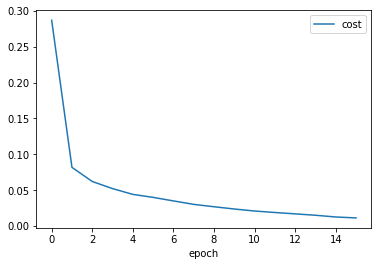

In [20]:
mu.plt_init()

for epoch in range(training_epochs + 1):
    avg_cost = 0

    for X, Y in data_loader:
        X = X.to(device)
        Y = Y.to(device)

        hypothesis = model(X)
        cost = criterion(hypothesis, Y)

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    mu.log_epoch(epoch, training_epochs, avg_cost)

mu.plt_show()



--- 
 - 이제 테스트를 해보겠습니다. 
 -98%의 정확도를 얻습니다. 다음 챕터에서는 층을 더 쌓아보겠습니다. 


In [21]:

# 학습을 진행하지 않을 것이므로 torch.no_grad()
with torch.no_grad():
    X_test = mnist_test.test_data.view(len(mnist_test), 1, 28, 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    mu.log("accuracy", accuracy)


/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")



accuracy : 
    torch.Size([]) 0.9520000219345093

